# Training a model on CarbonTracker's carbon flux
This notebook outlines the entire workflow to load and preprocess the following data sets, to be able to train a ML model:

- CarbonTracker
- ERA5 (monthly)
- ERA5-land (monthly)
- SPEI (monthly)
- MODIS (monthly)
- Biomass (yearly)
- Copernicus Landcover (yearly)

First follow the data downloading and config setup instuctions.

If you run this notebook on Surf Research Cloud, you shouldn't need to do this anymore.

We start by setting up a Dask client. This will ensure that Dask can run efficiently to process the data:

In [1]:
from dask.distributed import Client
client = Client()

/home/cdonnelly/excited-workflow/venv/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41689 instead
  warnings.warn(


In [2]:
import excited_workflow
from pathlib import Path
import xarray as xr
import xarray_regrid  # Importing this will make Dataset.regrid accessible.

We will load the CarbonTracker data into an xarray `Dataset` and convert the timestamps (middle point of each month) to a more standard format (1st day of the month), to allow merging with the other datasets.

In [3]:
ds_cb = xr.open_dataset("/data/volume_2/EXCITED_prepped_data/CT2022.flux1x1-monthly.nc")
ds_cb = excited_workflow.utils.convert_timestamps(ds_cb)

The other datasets can be found using the excited_workflow.source_datasets module:

In [4]:
from excited_workflow.source_datasets import datasets
datasets

{'biomass': <excited_workflow.source_datasets.biomass.Biomass at 0x7f5ca9a80690>,
 'era5_hourly': <excited_workflow.source_datasets.era5.ERA5Hourly at 0x7f5c674ba3d0>,
 'era5_monthly': <excited_workflow.source_datasets.era5.ERA5Monthly at 0x7f5c674bbe50>,
 'era5_land_monthly': <excited_workflow.source_datasets.era5.ERA5LandMonthly at 0x7f5c674b9ed0>,
 'copernicus_landcover': <excited_workflow.source_datasets.land_cover.LandCover at 0x7f5c674b8e10>,
 'modis': <excited_workflow.source_datasets.modis.Modis at 0x7f5c674d1990>,
 'spei': <excited_workflow.source_datasets.spei.Spei at 0x7f5c674d1050>}

We can loop over the desired datasets and merge them into a single xr.Dataset:

In [5]:
desired_data = [
    "biomass",
    "spei",
    "modis",
    "era5_monthly",
    "era5_land_monthly",
    "copernicus_landcover"
]
ds_input = xr.merge(
    [datasets[name].load(freq="monthly", target_grid=ds_cb) for name in desired_data]
)

To limit the analyis to Transcom region 2 (North America) we require the `regions.nc` file:

In [6]:
ds_regions = xr.open_dataset("/data/volume_2/EXCITED_prepped_data/regions.nc")
# Uncomment the next line to preview the region:
#ds_regions["transcom_regions"].where(ds_regions["transcom_regions"]==2).plot()

Now we can merge everything together. From the CarbonTracker file we only require the `bio_flux_opt` variable:

In [7]:
ds_merged = xr.merge([
    ds_cb[["bio_flux_opt"]], 
    ds_regions["transcom_regions"],
    ds_input,
])

To make computations faster and less memory intensive, we can reduce the scope to only North America.

This `.sel` operation reduces the size of the dataset from worldwide to only a rectangular area around North America:

In [8]:
time_region_na = {
    "time": slice("2000-01", "2019-12"),
    "latitude": slice(15, 60),
    "longitude": slice(-140, -55),
}
ds_na = ds_merged.sel(time_region_na)

In [9]:
ds_na = ds_na.compute()

From this North American dataset we can mask the transcom region, and preview the 2m air temperature of ERA5:

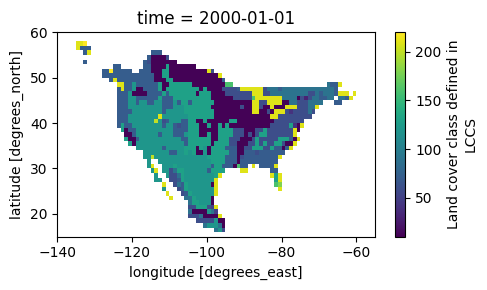

In [10]:
ds_na = ds_na.where(ds_merged["transcom_regions"]==2)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
ds_na["lccs_class"].isel(time=0).plot()
plt.tight_layout()

In [19]:
df_train = ds_na.to_dataframe().dropna()
df_train

bio_flux_opt  transcom_regions    biomass  \
time       latitude longitude                                              
2000-08-01 16.5     -97.5     -6.010017e-07               2.0  45.289826   
                    -96.5     -5.498427e-07               2.0  42.524410   
                    -95.5     -3.203208e-07               2.0  40.658878   
           17.5     -100.5    -7.650994e-07               2.0  46.187639   
                    -99.5     -2.389529e-06               2.0  41.231996   
...                                     ...               ...        ...   
2019-12-01 55.5     -114.5     5.078427e-07               2.0  23.803023   
                    -113.5     7.799189e-07               2.0  29.709211   
                    -112.5     8.044822e-07               2.0  15.008749   
           56.5     -131.5     5.528356e-07               2.0  64.364447   
           57.5     -132.5     1.015704e-07               2.0  13.424713   

                                   spei      NDVI      NIRv         d2m  \
time       latitude longitude                                             
2000-08-01 16.5     -97.5      0.402637  0.756299  0.264352  291.160736   
                    -96.5      0.859432  0.635423  0.186314  287.451385   
                    -95.5     -0.002091  0.714530  0.245570  292.602661   
           17.5     -100.5     0.364373  0.768887  0.270905  290.568329   
                    -99.5      0.007593  0.748444  0.249498  290.078156   
...                                 ...       ...       ...         ...   
2019-12-01 55.5     -114.5     0.650443  0.168989  0.014420  259.794739   
                    -113.5     0.582704  0.181974  0.015521  259.467133   
                    -112.5     0.328202  0.176154  0.017731  258.919037   
           56.5     -131.5    -0.181532 -0.066072 -0.038799  269.274261   
           57.5     -132.5     0.123489 -0.117813 -0.061499  266.016449   

                                    mslhf      msshf            sp  ...  \
time       latitude longitude                                       ...   
2000-08-01 16.5     -97.5     -123.552444 -29.256828  89704.265625  ...   
                    -96.5      -98.636139 -44.350342  83853.054688  ...   
                    -95.5      -88.933502 -76.770813  94853.679688  ...   
           17.5     -100.5    -118.364532 -51.205177  85797.492188  ...   
                    -99.5     -119.800644 -42.374344  85094.835938  ...   
...                                   ...        ...           ...  ...   
2019-12-01 55.5     -114.5      -2.107529  16.971649  92106.984375  ...   
                    -113.5      -1.547745  15.787460  92649.859375  ...   
                    -112.5      -0.648941  16.144135  93281.093750  ...   
           56.5     -131.5      -3.085175   0.307220  91528.421875  ...   
           57.5     -132.5      -1.342758  -2.474945  84002.898438  ...   

                                      skt        stl1        stl2        stl3  \
time       latitude longitude                                                   
2000-08-01 16.5     -97.5      293.800140  294.488708  294.490234  294.558624   
                    -96.5      291.346344  292.329987  292.415466  292.695587   
                    -95.5      298.976379  299.503906  299.532959  299.621643   
           17.5     -100.5     293.096253  293.790924  293.769348  293.723419   
                    -99.5      291.973236  292.737579  292.763458  292.868774   
...                                   ...         ...         ...         ...   
2019-12-01 55.5     -114.5     261.254547  272.136719  272.757507  274.221741   
                    -113.5     261.202423  268.530670  269.509583  273.085327   
                    -112.5     260.399170  268.575684  270.025513  273.835937   
           56.5     -131.5     265.012054  270.157807  270.336700  270.928772   
           57.5     -132.5     263.732574  267.186951  267.285309  267.666473   

                                    

To prepare the data for training, we convert it to a Pandas `DataFrame`.

In [12]:
import numpy as np
import pandas as pd
import pycaret.regression

df_train = ds_na.to_dataframe().dropna()
bins = 5
splits = np.array_split(df_train, bins)
for i in range(len(splits)):
    splits[i]['group'] = i + 1
    
df_train = pd.concat(splits)

df = df_train[df_train["group"] != 2]

In [13]:


X_keys = ["d2m", "mslhf", "msshf", "ssr", "str", "t2m", "spei", "NIRv", "skt", "stl1", "swvl1", "lccs_class"]
y_key = "bio_flux_opt"

df_pycaret = df_train[X_keys + [y_key]]
df_reduced = df_pycaret[::10]

df_reduced["bio_flux_opt"] = df_reduced["bio_flux_opt"]*1e6  # So RMSE etc. are easier to interpret.

import pycaret.regression
pycs = pycaret.regression.setup(df_reduced, target=y_key)
best = pycs.compare_models(n_select=5, round=2)



,Description,Value
0,Session id,3986
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(26656, 13)"
4,Transformed data shape,"(26656, 13)"
5,Transformed train set shape,"(18659, 13)"
6,Transformed test set shape,"(7997, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.32,0.24,0.49,0.76,0.23,4.19,1.29
rf,Random Forest Regressor,0.33,0.26,0.51,0.74,0.23,4.44,4.50
lightgbm,Light Gradient Boosting Machine,0.33,0.26,0.51,0.74,0.23,4.38,0.14
gbr,Gradient Boosting Regressor,0.35,0.28,0.53,0.72,0.24,5.08,2.13
ridge,Ridge Regression,0.46,0.43,0.65,0.57,0.30,7.62,0.01
br,Bayesian Ridge,0.46,0.43,0.65,0.57,0.30,7.73,0.01
ada,AdaBoost Regressor,0.50,0.43,0.66,0.57,0.32,9.76,0.50
lar,Least Angle Regression,0.47,0.44,0.66,0.56,0.30,7.86,0.02
dt,Decision Tree Regressor,0.48,0.54,0.73,0.46,0.32,6.47,0.09
lr,Linear Regression,0.50,0.54,0.73,0.46,0.32,8.54,0.23


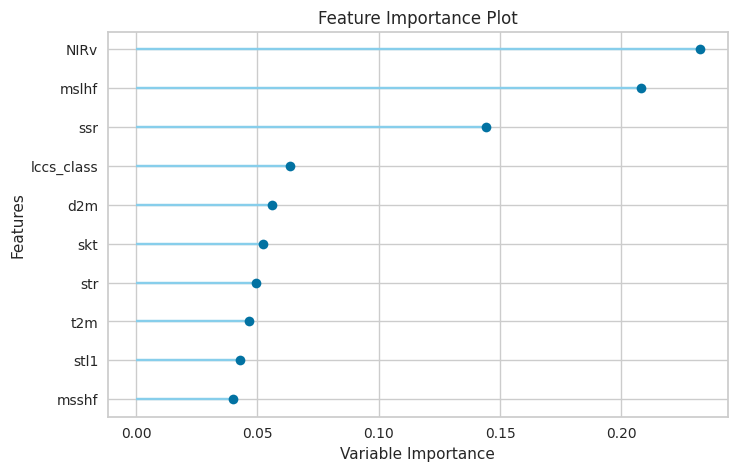

In [14]:

pycs.plot_model(best[0], plot="feature")

Now we can our ML models on the data. Here we use pycaret to try a set of models and see which type performs best.

Using pycaret, the trained models can be evaluated.

In [15]:
X_keys = ["biomass", "d2m", "mslhf", "msshf", "ssr", "str", "t2m", "spei", "NIRv", "skt", "stl1", "swvl1", "lccs_class"]
y_key = "bio_flux_opt"

df_pycaret = df_train[X_keys + [y_key]]
df_reduced = df_pycaret[::10]

df_reduced["bio_flux_opt"] = df_reduced["bio_flux_opt"]*1e6  # So RMSE etc. are easier to interpret.

import pycaret.regression
pycs = pycaret.regression.setup(df_reduced, target=y_key)
best = pycs.compare_models(round=2)

,Description,Value
0,Session id,7571
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(26656, 14)"
4,Transformed data shape,"(26656, 14)"
5,Transformed train set shape,"(18659, 14)"
6,Transformed test set shape,"(7997, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.31,0.23,0.47,0.77,0.22,3.88,1.41
lightgbm,Light Gradient Boosting Machine,0.32,0.23,0.48,0.77,0.22,3.81,0.09
rf,Random Forest Regressor,0.32,0.24,0.49,0.76,0.22,4.30,4.90
gbr,Gradient Boosting Regressor,0.34,0.26,0.51,0.73,0.24,4.72,2.29
ridge,Ridge Regression,0.45,0.41,0.64,0.59,0.29,7.32,0.01
br,Bayesian Ridge,0.47,0.44,0.66,0.56,0.31,8.53,0.02
ada,AdaBoost Regressor,0.50,0.43,0.66,0.56,0.32,9.59,0.53
dt,Decision Tree Regressor,0.46,0.48,0.70,0.51,0.31,6.21,0.11
lr,Linear Regression,0.49,0.52,0.72,0.47,0.32,8.27,0.01
lasso,Lasso Regression,0.50,0.56,0.75,0.44,0.32,7.65,0.02


2023-11-30 15:30:10,056 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-11-30 15:30:10,447 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-11-30 15:30:10,897 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-11-30 15:30:11,289 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2023-11-30 15:30:11,693 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-11-30 15:30:12,088 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-11-30 15:30:12,504 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-11-30 15:30:12,995 - distributed.utils_perf - WARNING - full garbage collections took

By including biomass info, we get a slightly better model performance.

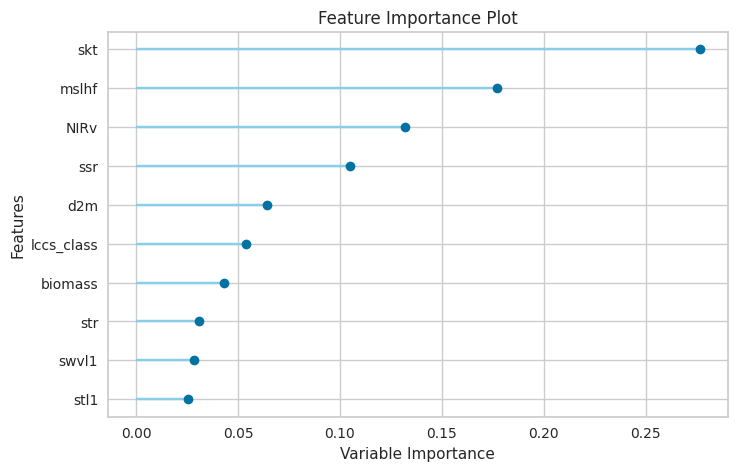

2023-11-30 15:31:51,381 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


In [16]:
pycs.plot_model(best[0], plot="feature")

However, in the feature importance plot you can see that the importance of NIRv is now reduced by including biomass info:

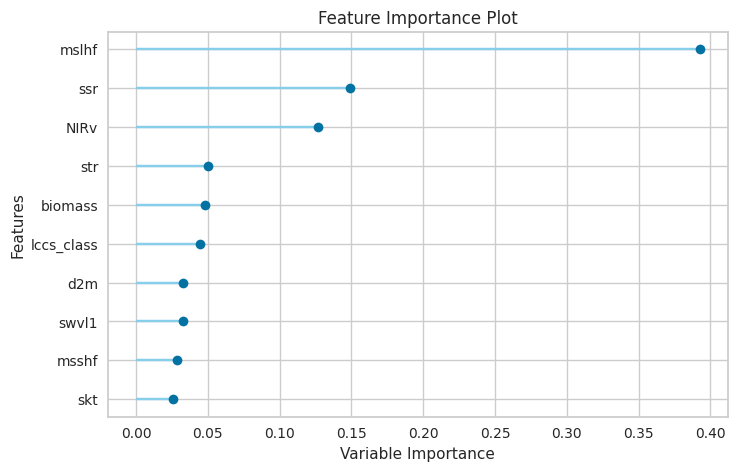

2023-11-30 15:31:51,883 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


In [17]:
pycs.plot_model(best[3], plot="feature")

However, this feature imporance depends on the model used. For a different well performing model, the feature imporance is the following:

In [18]:
biomass_pycs.plot_model(biomass_best[3], plot="feature")

NameError: name 'biomass_pycs' is not defined